<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30000 non-null  object
 1   label   30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.9+ KB


,text,label
0,Tim Burton is in essence an expressionist film...,1
1,This tale based on two Edgar Allen Poe pieces ...,1
2,"Dead or Alive: Final, the movie that supposedl...",1
3,Certainly this film has the ring of truth abou...,1
4,It pains me to say this about an Australian fi...,0


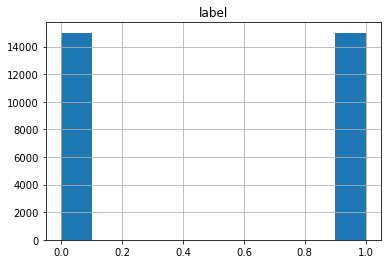

In [1]:
import pandas as pd

df_train = pd.read_json("../data/aclIMDB_train.json", orient='records')
df_train.info()
df_train.hist()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


,text,label
0,This was Barbra Streisand's first television s...,1
1,"I am, as many are, a fan of Tony Scott films. ...",0
2,A young scientist Harry Harrison is continuing...,0
3,"Anthony McGarten has adapted his play, Via Sat...",1
4,"I was watching this movie on Friday,Apr 7th. I...",1


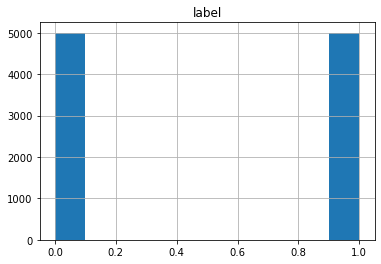

In [2]:
df_val = pd.read_json("../data/aclIMDB_val.json", orient="records")
df_val.info()
df_val.hist()
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


,text,label
0,This movie features Charlie Spradling dancing ...,0
1,L'Hypothèse du tableau volé/The Hypothesis of ...,1
2,Surprisingly well made little movie. Short in ...,1
3,I rented this because I'm a bit weary of '80s ...,0
4,"Twenty years ago, the five years old boy Micha...",0


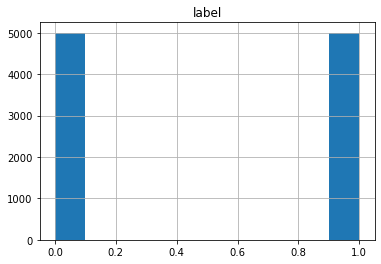

In [3]:
df_test = pd.read_json("../data/aclIMDB_test.json", orient='records')
df_test.info()
df_test.hist()
df_test.head()

In [4]:
train = [str(item).lower() for item in  df_train["text"].values]
val = [str(item).lower() for item in  df_val["text"].values]
test = [str(item).lower() for item in  df_test["text"].values]

In [5]:
import tensorflow as tf

VOCAB_SIZE = 10000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="UNK")
tokenizer.fit_on_texts(train)

X_train_wordlevel = tokenizer.texts_to_sequences(train)
X_val_wordlevel = tokenizer.texts_to_sequences(val)
X_test_wordlevel = tokenizer.texts_to_sequences(test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 96002 unique tokens.


In [6]:
print(X_train_wordlevel[0][:10])

[1827, 3853, 7, 9, 3417, 33, 1, 20, 2751, 1]


In [7]:
import numpy as np
from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer("../data/bert-base-uncased-vocab.txt", lowercase=True)

def bert_tokenizer(data):
    result = []
    for item in data:
        result.append(tokenizer.encode(item).ids)
    
    return np.array(result)

In [8]:
X_train_bert = bert_tokenizer(train)
X_val_bert = bert_tokenizer(val)
X_test_bert = bert_tokenizer(test)

In [9]:
print(X_train_bert[0][:10])

[101, 5199, 9658, 2003, 1999, 11305, 2019, 3670, 2923, 2143]


In [10]:
maxlen = 128

X_train_bert = tf.keras.preprocessing.sequence.pad_sequences(X_train_bert, maxlen=maxlen)
X_val_bert = tf.keras.preprocessing.sequence.pad_sequences(X_val_bert, maxlen=maxlen)
X_test_bert = tf.keras.preprocessing.sequence.pad_sequences(X_test_bert, maxlen=maxlen)

X_train_wordlevel = tf.keras.preprocessing.sequence.pad_sequences(X_train_wordlevel, maxlen=maxlen)
X_val_wordlevel = tf.keras.preprocessing.sequence.pad_sequences(X_val_wordlevel, maxlen=maxlen)
X_test_wordlevel = tf.keras.preprocessing.sequence.pad_sequences(X_test_wordlevel, maxlen=maxlen)

y_train = np.array(df_train["label"].values)
y_val = np.array(df_val["label"].values)
y_test = np.array(df_test["label"].values)

In [11]:
import tensorflow as tf

model_wordlevel = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, 8, input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
]) 

model_wordlevel.compile(optimizer='adam',
                   loss="binary_crossentropy",
                   metrics=['binary_accuracy'])

model_wordlevel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 8)            768024    
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 833,689
Trainable params: 833,689
Non-trainable params: 0
_________________________________________________________________


In [12]:
h_wordlevel = model_wordlevel.fit(X_train_wordlevel, 
                                  y_train,
                                  epochs=5,
                                  batch_size=32,
                                  validation_data=(X_val_wordlevel, y_val))

Epoch 1/5
938/938 [==============================] - 17s 18ms/step - loss: 0.3894 - binary_accuracy: 0.8107 - val_loss: 0.3328 - val_binary_accuracy: 0.8529
Epoch 2/5
938/938 [==============================] - 16s 17ms/step - loss: 0.1818 - binary_accuracy: 0.9286 - val_loss: 0.3972 - val_binary_accuracy: 0.8415
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0610 - binary_accuracy: 0.9803 - val_loss: 0.6378 - val_binary_accuracy: 0.8296
Epoch 4/5
938/938 [==============================] - 19s 20ms/step - loss: 0.0163 - binary_accuracy: 0.9958 - val_loss: 0.8921 - val_binary_accuracy: 0.8279
Epoch 5/5
938/938 [==============================] - 19s 20ms/step - loss: 0.0042 - binary_accuracy: 0.9993 - val_loss: 1.0034 - val_binary_accuracy: 0.8323


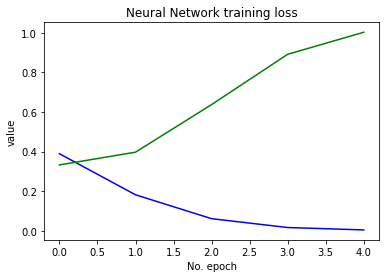

In [13]:
import matplotlib.pyplot as plt

plt.plot(h_wordlevel.history['loss'], label='(training data)',color='blue')
plt.plot(h_wordlevel.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network training loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

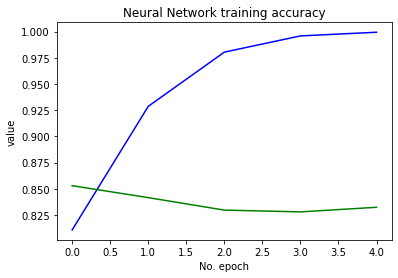

In [14]:
import matplotlib.pyplot as plt

plt.plot(h_wordlevel.history['binary_accuracy'], label='(training data)',color='blue')
plt.plot(h_wordlevel.history['val_binary_accuracy'], label='(val data)',color='green')
plt.title('Neural Network training accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [15]:
import tensorflow as tf

max_features = 30523  # vocab size

model_bert = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, 8, input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
]) 

model_bert.compile(optimizer='adam',
                   loss="binary_crossentropy",
                   metrics=['binary_accuracy'])

model_bert.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 8)            244184    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 245,209
Trainable params: 245,209
Non-trainable params: 0
_________________________________________________________________


In [16]:
h_bert = model_bert.fit(X_train_bert, 
                        y_train,
                        epochs=5,
                        batch_size=32,
                        validation_data=(X_val_bert, y_val))

Epoch 1/5
938/938 [==============================] - 6s 6ms/step - loss: 0.5316 - binary_accuracy: 0.7316 - val_loss: 0.3696 - val_binary_accuracy: 0.8361
Epoch 2/5
938/938 [==============================] - 5s 5ms/step - loss: 0.2709 - binary_accuracy: 0.8909 - val_loss: 0.3404 - val_binary_accuracy: 0.8475
Epoch 3/5
938/938 [==============================] - 6s 7ms/step - loss: 0.1870 - binary_accuracy: 0.9326 - val_loss: 0.3482 - val_binary_accuracy: 0.8455
Epoch 4/5
938/938 [==============================] - 6s 6ms/step - loss: 0.1274 - binary_accuracy: 0.9605 - val_loss: 0.3692 - val_binary_accuracy: 0.8446
Epoch 5/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0823 - binary_accuracy: 0.9822 - val_loss: 0.4034 - val_binary_accuracy: 0.8389


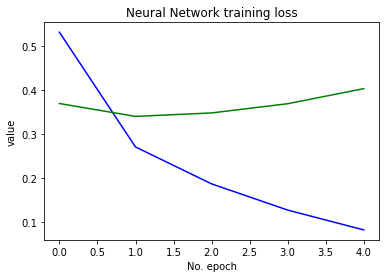

In [17]:
import matplotlib.pyplot as plt

plt.plot(h_bert.history['loss'], label='(training data)',color='blue')
plt.plot(h_bert.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network training loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

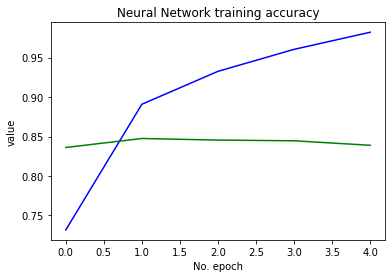

In [18]:
import matplotlib.pyplot as plt

plt.plot(h_bert.history['binary_accuracy'], label='(training data)',color='blue')
plt.plot(h_bert.history['val_binary_accuracy'], label='(val data)',color='green')
plt.title('Neural Network training accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [19]:
results = model_wordlevel.evaluate(X_test_wordlevel, y_test, batch_size=32)
print("test loss, test acc:", results)

313/313 [==============================] - 1s 2ms/step - loss: 1.0090 - binary_accuracy: 0.8373
test loss, test acc: [1.0090153217315674, 0.8373000025749207]


In [20]:
results = model_bert.evaluate(X_test_bert, y_test, batch_size=32)
print("test loss, test acc:", results)

313/313 [==============================] - 1s 2ms/step - loss: 0.4075 - binary_accuracy: 0.8447
test loss, test acc: [0.4074641466140747, 0.8446999788284302]


In [21]:
df_test_raw = pd.read_json("../data/aclIMDB_test.json", orient="records")

In [22]:
predictions_bert = np.round(model_bert.predict(X_test_bert[:5]),0)
predictions_wordlevel = np.round(model_wordlevel.predict(X_test_wordlevel[:5]),0)

for i in range(len(predictions_bert)):
    print(df_test_raw["text"].values[i][:100],"...")
    print("Pred Wordlevel:", predictions_wordlevel[i][0], "Pred BERT:", predictions_bert[i][0], "Real:", y_test[i])

This movie features Charlie Spradling dancing in a strip club. Beyond that, it features a truly bad  ...
Pred Wordlevel: 0.0 Pred BERT: 0.0 Real: 0
L'Hypothèse du tableau volé/The Hypothesis of the Stolen Painting (1979) begins in the courtyard of  ...
Pred Wordlevel: 1.0 Pred BERT: 1.0 Real: 1
Surprisingly well made little movie. Short in length at about 90 minutes. For a low budget movie, ve ...
Pred Wordlevel: 1.0 Pred BERT: 1.0 Real: 1
I rented this because I'm a bit weary of '80s NBC programming and apparently I saved myself a lot of ...
Pred Wordlevel: 0.0 Pred BERT: 0.0 Real: 0
Twenty years ago, the five years old boy Michael Hawthorne witnessed his father killing his mother w ...
Pred Wordlevel: 1.0 Pred BERT: 0.0 Real: 0
